# AP-1 FDR Analysis

## Imports

In [ ]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import matplotlib_venn
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('talk')

In [ ]:
workingDirectory = '/home/jtao/analysis/ap1_fdr_analysis/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)
peakDirectory = '/home/jtao/analysis/ap1_fdr_analysis/peak_files/'
tagDirPath = '/home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1/'

In [ ]:
# file directories

os.chdir(workingDirectory)

# read in and parse name mapping file and create a DataFrame representation

strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
sampleNames = []

for sample in sorted(os.listdir(tagDirPath)):
    metaDataTokens = sample.strip().split("_")
    
    sampleNames.append(sample)
    
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  sampleNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.split('-')[0]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

### read in log files ###

# create data frame summarizing mapping quality logs
_sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_tagsPerPosition = []
for sample in [x for x in sorted(os.listdir(tagDirPath)) if not 'nput' in x and not 'p65' in x and not 'cebp' in x]:
    logFile = [x for x in os.listdir(tagDirPath + '/' + sample) if '.log'in x][0] # find mapping log file
    
    with open(tagDirPath + '/' + sample + '/' + logFile) as f:
        data = f.readlines()
            
    totalReads = float(data[0].split()[0])
    unpairedReads = float(data[1].split()[0])
    unmappedReads = float(data[2].split()[0])
    uniquelyMappedReads = float(data[3].split()[0])
    multiMappedReads = float(data[4].split()[0])

    _sampleNames.append(sample)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        tpp = float(data[5].strip().split('=')[1])
        _tagsPerPosition.append(tpp)
mappingStats_frame = pd.DataFrame([_sampleNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _tagsPerPosition]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'tagsPerPosition']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']



summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
mapping_summary_frame = summary_frame.sort()

In [ ]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 1000000

filtered_summary_frame = mapping_summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['mappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame['strain'] 
                            + '_' + filtered_summary_frame['factor'] 
                            + '_' + filtered_summary_frame["simpleTreatment"]
                            + '_' + filtered_summary_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_frame['sampleName'].values,
                                       filtered_summary_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_frame['simplifiedName'].values,
                                       filtered_summary_frame['sampleName'].values))

## Peak Calling

In [ ]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile = open('./peakCalling_homer.sh', 'w')


for tagDir in filtered_summary_frame['sampleName'].values:
    # call peaks only for experiments that passed thresholding
    metaDataTokens = tagDir.split("_")
    treatment = metaDataTokens[4]

    peakFileName = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"

    if "veh" in treatment.lower():
        inputDir = '/home/jtao/analysis/ap1_analysis/input_data/C57Bl6_Thiomac_ChIP_Input_Veh_GJF_15-03-20'
    elif "kla" in treatment.lower():
        inputDir = '/home/jtao/analysis/ap1_analysis/input_data/C57Bl6_Thiomac_ChIP_Input_KLA-1h_GJF_15-03-20'
    
    scriptFile.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                 ' -i ' + inputDir
                 + ' -style factor -size 200 -norm 1e6 > ' + 
                 peakDirectory +'/' + peakFileName + ' &\n')
scriptFile.close()

In [ ]:
%%bash
rm ./peak_files/*
chmod a+x ./*sh
bash ./peakCalling_homer.sh

## Copy IDR Peak files

In [ ]:
%%bash
if [ ! -d ./idr_peak_files ]; then mkdir ./idr_peak_files; else rm ./idr_peak_files/*; fi
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_files/c57bl6* ./idr_peak_files/
rm ./idr_peak_files/*p65*
rm ./idr_peak_files/*cebp*
for i in ./idr_peak_files/*;
    do mv $i ${i/_peaks.tsv/_idr_peaks.tsv};
done

## Peak Filtering

In [ ]:
# filter away peaks that have less than 16 normalized tags
# rename peak files to remove redundant information
chroms = ['chr1',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chrX']
seen_conditions = set()
peakDirectory = './peak_files/'
filtered_peak_directory = './filtered_peak_files/'
if not os.path.isdir(filtered_peak_directory):
    os.mkdir(filtered_peak_directory)
for f in os.listdir(peakDirectory):
    print(f)
    tokens = f.split('_')
    condition = tokens[0] +'_'+ tokens[1] + '_' + tokens[2]
    
    if condition in seen_conditions:
        new_name = filtered_peak_directory+'/'+condition + '_rep2_peaks.tsv' 
    else:
        new_name = filtered_peak_directory+'/'+condition + '_rep1_peaks.tsv' 
        seen_conditions.add(condition)
    current_frame = pd.read_csv(peakDirectory + '/' + f, sep = '\t', skiprows=39)
    filtered_frame = current_frame[(current_frame['chr'].isin(chroms)) &
                                  (current_frame['Normalized Tag Count'] >= 1)]
    filtered_frame.to_csv(new_name, sep='\t', index=False)

In [ ]:
# filter away peaks that have less than 16 normalized tags
# rename peak files to remove redundant information
chroms = ['chr1',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chrX']
seen_conditions = set()
filtered_peak_directory = './filtered_idr_peak_files/'
if not os.path.isdir(filtered_peak_directory):
    os.mkdir(filtered_peak_directory)
peakDirectory = './idr_peak_files/'
for f in os.listdir(peakDirectory):
    print(f)
    tokens = f.split('_')
    condition = tokens[0] +'_'+ tokens[1] + '_' + tokens[2]
    new_name = filtered_peak_directory+'/'+condition + '_idr_peaks.tsv' 
    current_frame = pd.read_csv(peakDirectory + '/' + f, sep = '\t')
    filtered_frame = current_frame[current_frame['chr'].isin(chroms)]
    filtered_frame.to_csv(new_name, sep='\t', index=False)

## Merge Peaks

In [101]:
%%capture
%%bash
mergePeaks -d 100 ./filtered_idr_peak_files/*tsv ./filtered_peak_files/*tsv > merged_peaks.tsv

makeSummaryFile.py ./merged_peaks.tsv ./group_summary.tsv ./filtered_peak_files/*tsv ./filtered_idr_peak_files/*tsv

## Annotate Peaks

In [104]:
%%bash
annotatePeaks.pl ./merged_peaks.tsv mm10 -d /home/jtao/analysis/cobinding_motif_analysis/tag_directories_ap1/*/ > annotated_peaks.tsv

Process is interrupted.


## Convert to BED Files

In [ ]:
%%bash
# individual replicates
if [ ! -d ./bed_files ]; then mkdir ./bed_files/; else rm ./bed_files/*; fi

for i in ./filtered_peak_files/*tsv;
    do echo $i;
    outpath=./bed_files/${i##*/}
    outpath=${outpath/_peaks.tsv/.bed}
    echo $outpath
    pos2bed.pl $i > ./tmp
    tail -n +2 ./tmp > $outpath
done

# idr peaks
for i in ./filtered_idr_peak_files/*tsv;
    do echo $i;
    outpath=./bed_files/${i##*/}
    outpath=${outpath/_peaks.tsv/.bed}
    echo $outpath
    pos2bed.pl $i > ./tmp
    tail -n +2 ./tmp > $outpath
done
rm tmp



## Extract Sequences

In [ ]:
%%bash
if [ ! -d ./fasta_files ]; then mkdir ./fasta_files/; else rm ./fasta_files/*; fi

for i in ./bed_files/*bed; 
    do echo $i;
    outpath=./fasta_files/${i##*/}
    outpath=${outpath/.bed/.fasta}
    /gpfs/data01/glasslab/home/jtao/code/tba/extract_sequences.py $i mm10 $outpath
done

## Construct Background

In [ ]:
%%bash
rm ./make_background.sh
script_path="./make_background.sh"
if [ ! -d ./background/ ]; then mkdir ./background/ ; fi
for i in ./bed_files/*bed;
do 
    factor=${i##*/};
    factor=${factor%.bed};

    fasta_path="./background/${factor}_background.fasta"
    bed_path="./background/${factor}_background.bed"
    if [ ! -f $fasta_path ];
    then
    echo "/home/jtao/code/tba/generate_background_coordinates.py $i ./background/ -genome mm10";
    echo "mv ./background/background.bed $bed_path";
    echo "mv ./background/background.fasta $fasta_path";
    echo "/home/jtao/code/tba/generate_background_coordinates.py $i ./background/ -genome mm10" >> $script_path;
    echo "mv ./background/background.bed $bed_path" >> $script_path;
    echo "mv ./background/background.fasta $fasta_path" >> $script_path;
    fi
done

In [ ]:
%%bash
rm ./background/*
chmod a+x ./*sh
bash ./make_background.sh

## Create Features

In [95]:
%%bash
positive_seq_dir="./fasta_files/"
negative_seq_dir="./background/"
out_dir="./tba_output/"
script_path='./calculate_features.sh'
motif_dir='./jaspar_2016_curated_homerFormat/'
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for positive_seq_path in $positive_seq_dir/*;
    do factor=${positive_seq_path##./*/};
    factor=${factor%.fasta};

    negative_seq_path=${negative_seq_dir}/${factor}_background.fasta;
    echo "python /home/jtao/code/tba/create_features.py $positive_seq_path $negative_seq_path $out_dir ${motif_dir}/* -num_proc 28" >>$script_path
    echo "mv $out_dir/labels.txt $out_dir/${factor}_labels.txt" >> $script_path
    echo "mv $out_dir/standardized_features.tsv $out_dir/${factor}_standardized_features.tsv" >> $script_path
done

## Train Models

In [287]:
%%bash
feature_dir="./tba_output/"
out_dir="./tba_output/"
script_path='./train_classifier.sh'
iterations="5"
test_fraction="0.2"
if [ -f $script_path ]; then rm $script_path; else touch $script_path; fi
if [ ! -d $out_dir ]; then mkdir $out_dir; fi

for feature_path in $feature_dir/*standardized_features.tsv;
    do factor=${feature_path##./*/};
    factor=${factor%_*_*};
    label_path=${feature_path/standardized_features/labels};
    label_path=${label_path/tsv/txt};
    echo "python /home/jtao/code/tba/train_classifier.py $feature_path $label_path $out_dir -test_fraction $test_fraction -num_iterations $iterations" >>$script_path
    echo "mv $out_dir/performance.tsv $out_dir/${factor}_performance.tsv" >> $script_path
    echo "mv $out_dir/coefficients.tsv $out_dir/${factor}_coefficients.tsv" >> $script_path
done

## Compare Models

In [312]:
sample_weights_dict = {}
for f in os.listdir('./tba_output/'):
    if 'coefficients' in f:
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        mean_weights = frame.median(axis=1)
        sample = '_'.join(f.split('_')[1:4])
        sample_weights_dict[sample] = mean_weights
mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)

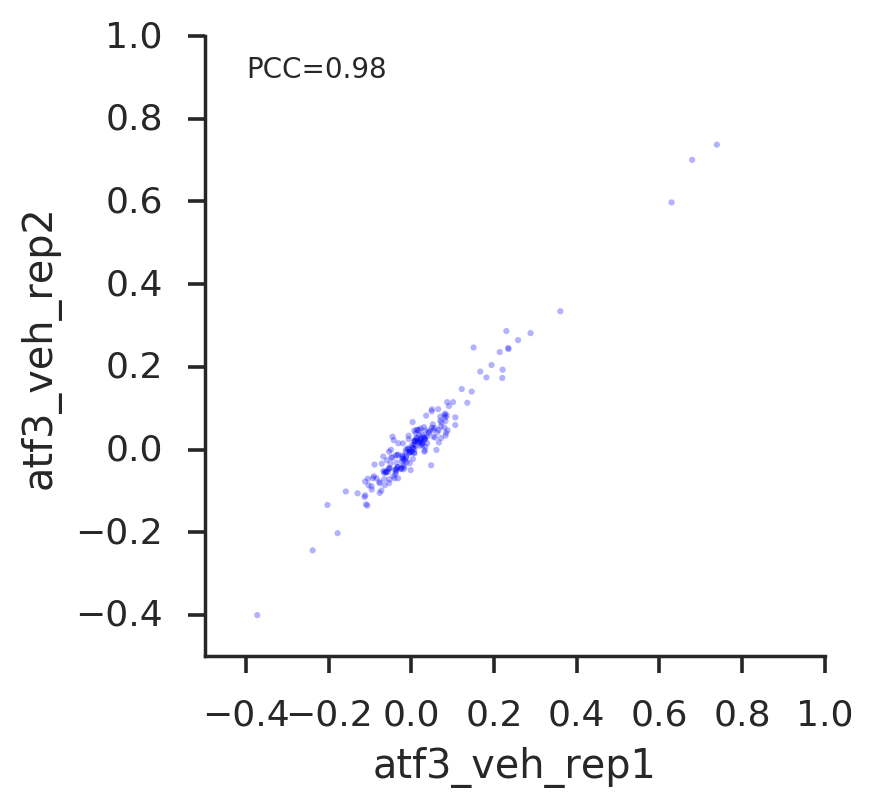

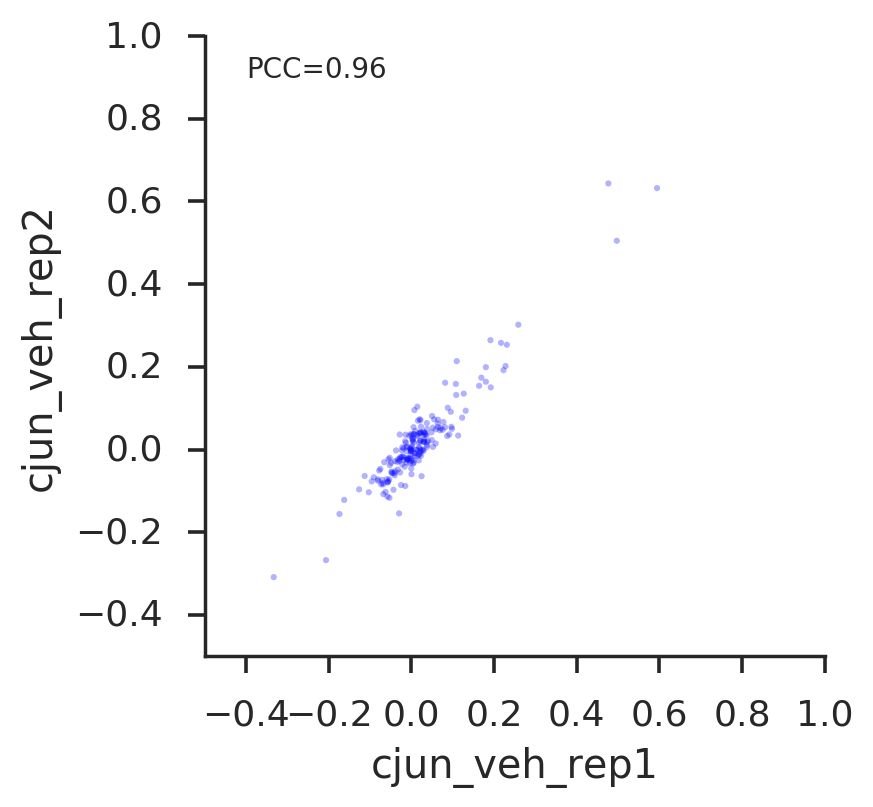

In [318]:
for treatment in ['veh']:
    for factor in ['atf3', 'cjun']:
        rep1_label = '_'.join([factor, treatment, 'rep1'])
        rep2_label = '_'.join([factor, treatment, 'rep2'])
        idr_label = '_'.join([factor, treatment, 'idr'])
        
        rep1_weights = mean_weights_frame[rep1_label].values
        rep2_weights = mean_weights_frame[rep2_label].values
        idr_weights = mean_weights_frame[idr_label].values
        
        rep_corr, pval = scipy.stats.pearsonr(rep1_weights, rep2_weights)
        rep1_corr, pval = scipy.stats.pearsonr(idr_weights, rep1_weights)
        rep2_corr, pval = scipy.stats.pearsonr(idr_weights, rep2_weights)
        
        with sns.axes_style('ticks'):
            plt.figure(figsize=(4,4))
            plt.scatter(rep1_weights,
                        rep2_weights,
                        edgecolor='None', 
                        s=5,
                        alpha=0.3)
            plt.annotate(xy=(-0.4,0.9), s='PCC='+str(rep_corr)[:4], size=10)
            plt.xlim(-0.5, 1)
            plt.ylim(-0.5, 1)
            ax = plt.gca()
            ax.set_aspect(1.0)
            plt.xlabel(rep1_label)
            plt.ylabel(rep2_label)
            sns.despine()

In [316]:
mean_weights_frame.ix[['ap-1', 'cebp', 'nr2f1', 'spi1-c', 'pparg'], 
                      ['cjun_veh_rep1', 'cjun_veh_rep2', 'cjun_veh_idr', 
                       'atf3_veh_rep1', 'atf3_veh_rep2', 'atf3_veh_idr']]

,cjun_veh_rep1,cjun_veh_rep2,cjun_veh_idr,atf3_veh_rep1,atf3_veh_rep2,atf3_veh_idr
ap-1,0.986514,1.028095,1.287552,0.931217,1.017501,1.195872
cebp,0.476883,0.643636,0.688710,0.739294,0.737556,0.884879
nr2f1,0.022381,0.070919,0.101339,0.057591,0.029006,0.029805
spi1-c,0.594641,0.632363,0.767806,0.679427,0.700767,0.775750
pparg,-0.059193,-0.071814,-0.075038,-0.040504,-0.069868,-0.061770


## Compare Replicates and IDR

In [122]:
# read in peak data data
summary_frame = pd.read_csv('./group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]

# remove c57bl6 from columns
columns = summary_frame.columns.values
columns = [x.replace('c57bl6_','') for x in columns]
summary_frame.columns = columns

# remove c57bl6 from Factors column
cleaned_factors = [x.replace('c57bl6_','') for x in summary_frame['Factors'].values]
summary_frame['Factors'] = cleaned_factors

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,6,7,8,10,11,12,13,16,19,20,21,22,23,24,25,26,27,28,29,30,31,33,35,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


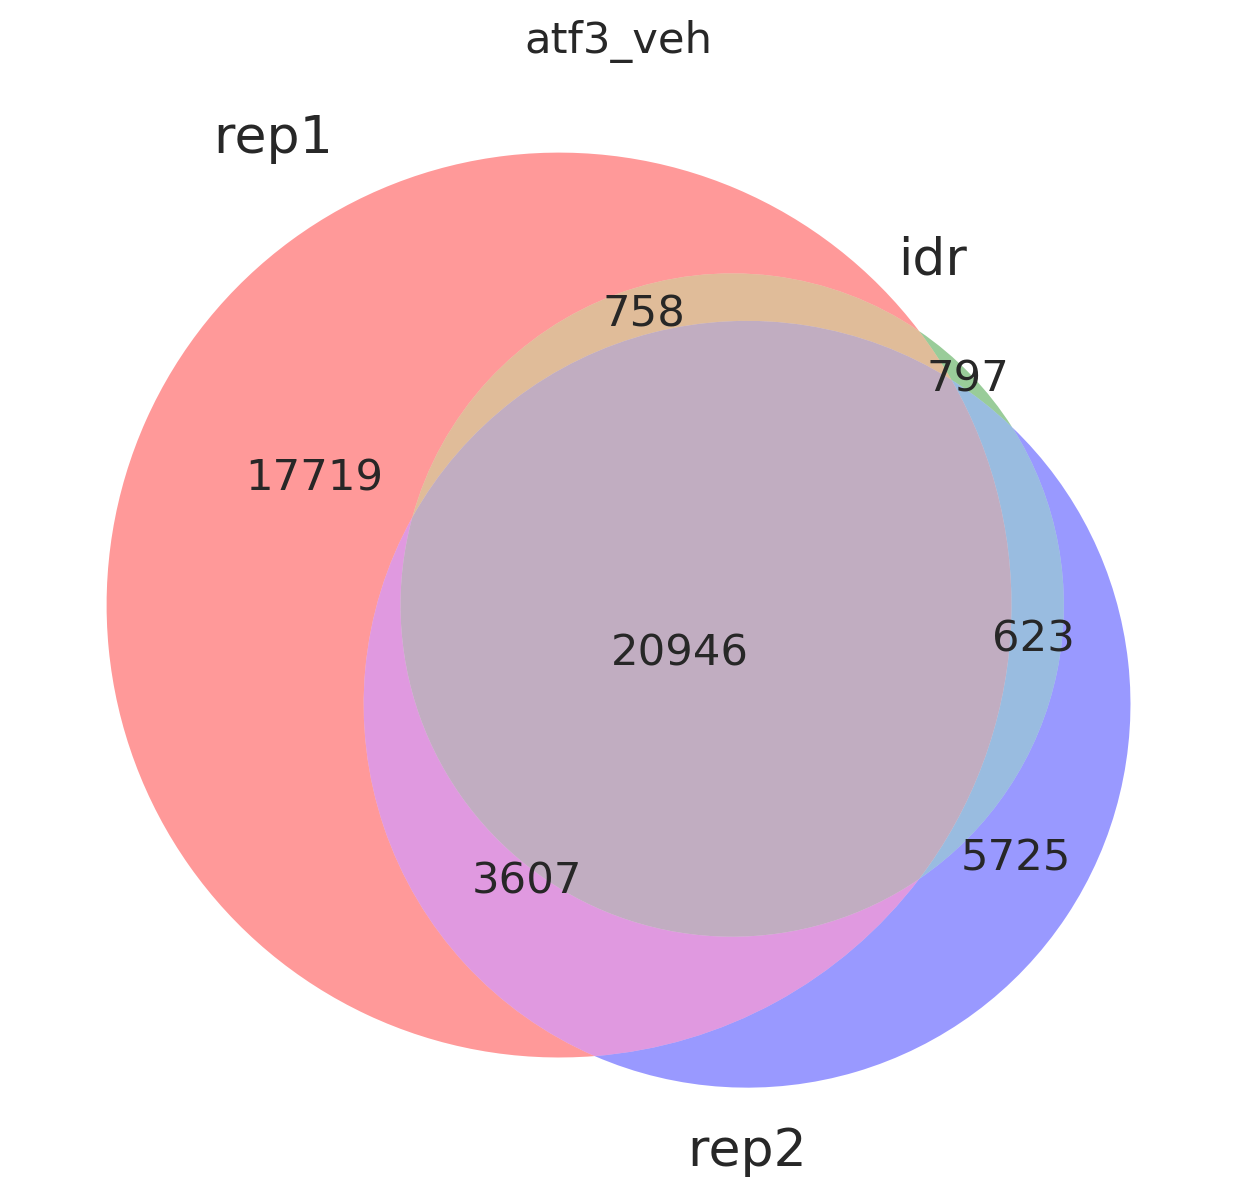

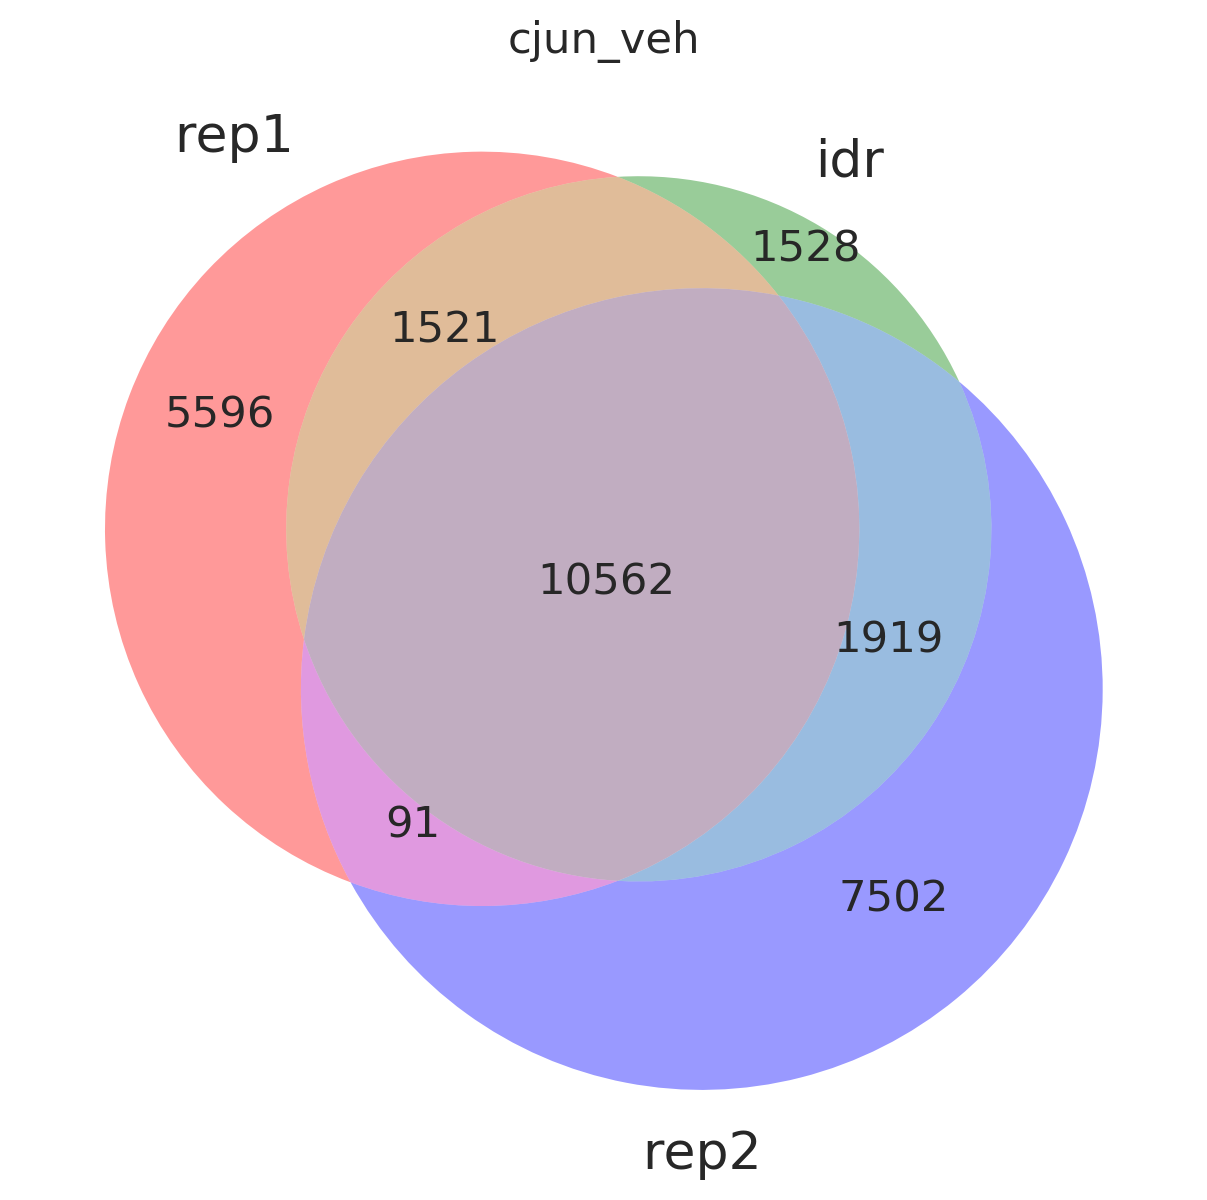

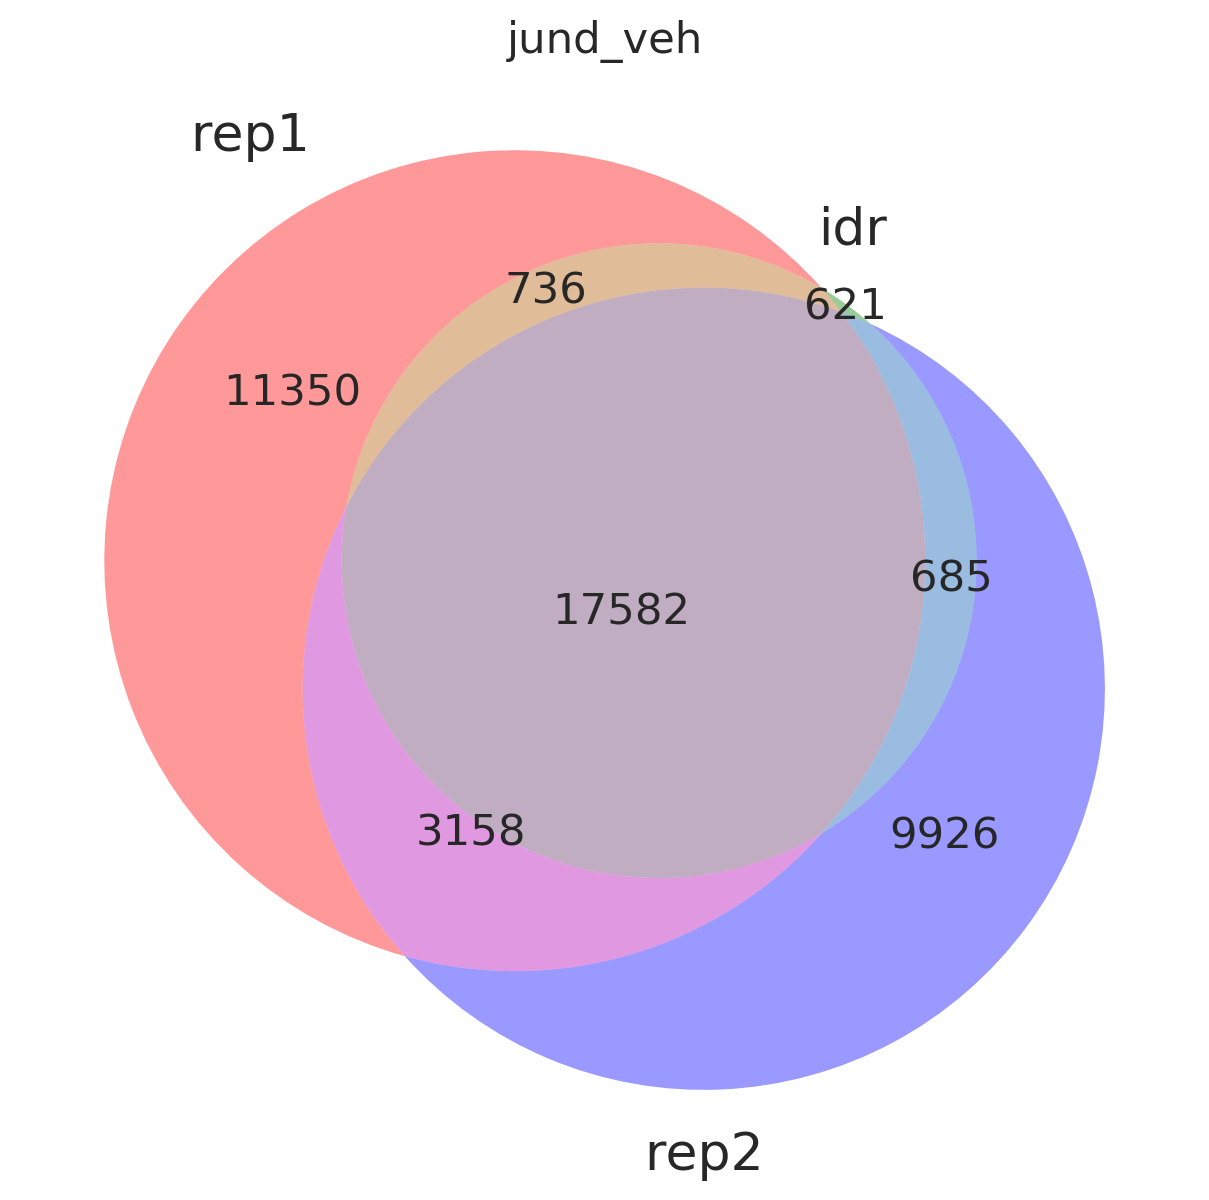

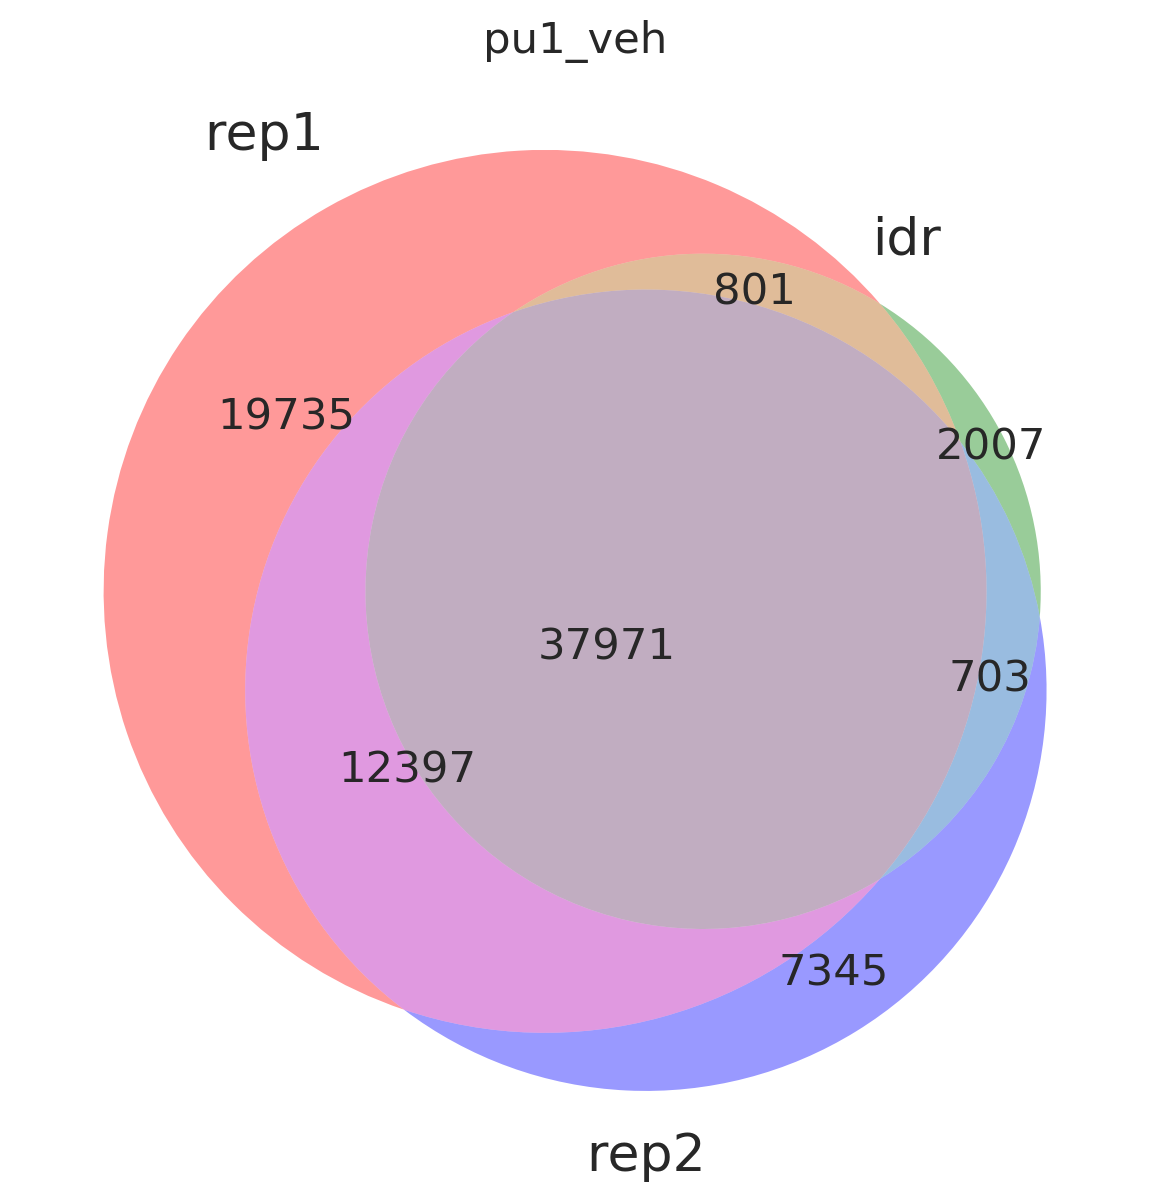

In [153]:
for treatment in ['veh']:
    for factor in ['atf3', 'cjun', 'jund', 'pu1']:
        rep1_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'rep1'])] > 0].index.values)
        rep2_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'rep2'])] > 0].index.values)
        idr_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'idr'])] > 0].index.values)
        matplotlib_venn.venn3([rep1_indices, idr_indices, rep2_indices], set_labels=['rep1', 'idr', 'rep2'])
        plt.title('_'.join([factor, treatment]))
        plt.show()

## Compare Tag Counts

In [162]:
annotated_frame = pd.read_csv('./annotated_peaks.tsv', sep='\t')
annotated_frame['Annotation'] = [x.split(' ')[0] for x in annotated_frame['Annotation'].astype(str)]

columns = list(annotated_frame.columns.values)
columns = columns[:4] + ['Annotation', 'Gene Name'] + [x for x in columns[1:] if 'Tag Count' in x]
annotated_frame = annotated_frame[columns]
columns[0] = 'PeakID'
columns = [x.split('/')[-2].split(' ')[0] if '/' in x else x for x in columns]

seen_conditions = set()
for i in range(6, len(columns)):
    col = columns[i]
    tokens = col.split('_')
    condition = tokens[3] + '_' + tokens[4]
    condition = condition.lower().replace('-1h','')
    if condition in seen_conditions:
        new_col = condition + '_rep2'
    else:
        new_col = condition + '_rep1'
    seen_conditions.add(condition)
    columns[i] = new_col

annotated_frame.columns = columns
annotated_frame.index = annotated_frame['PeakID'].values

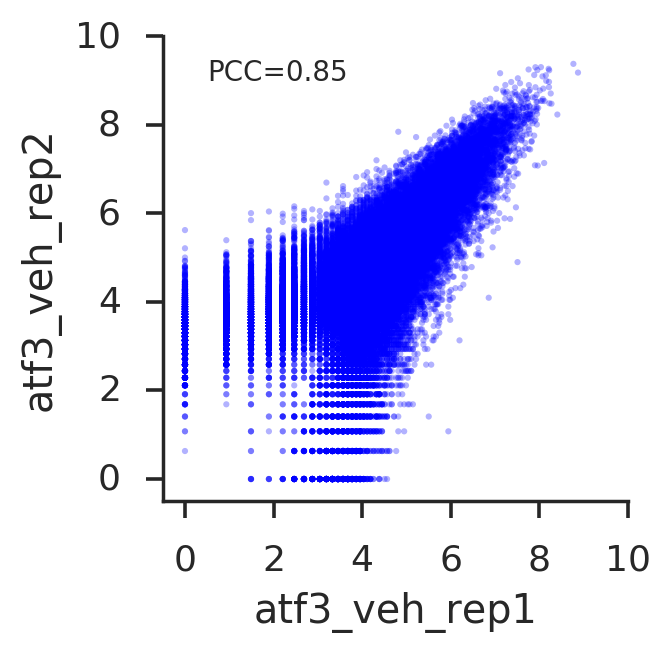

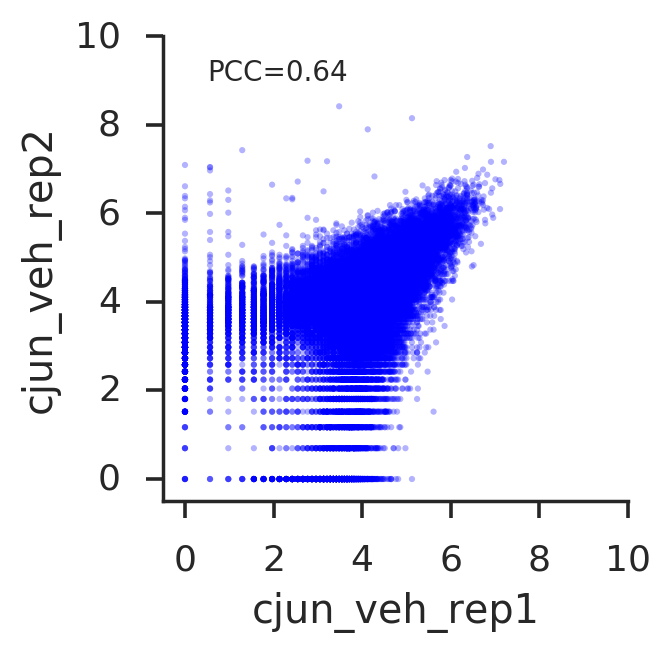

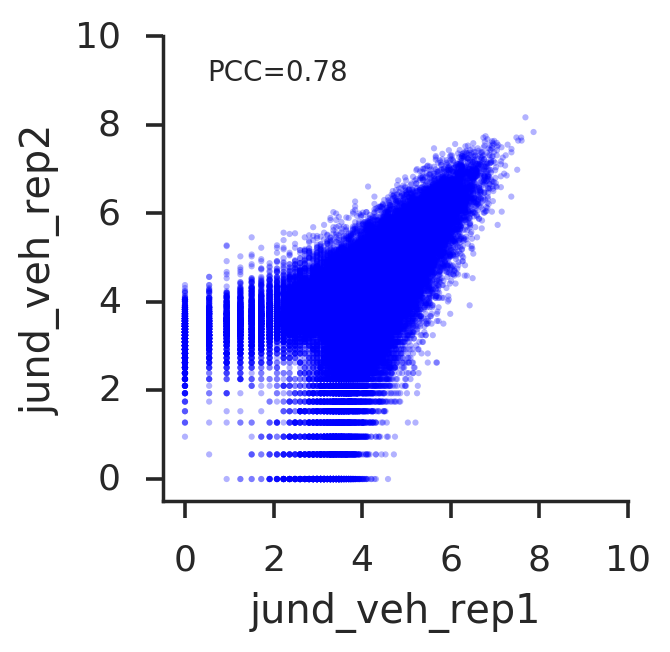

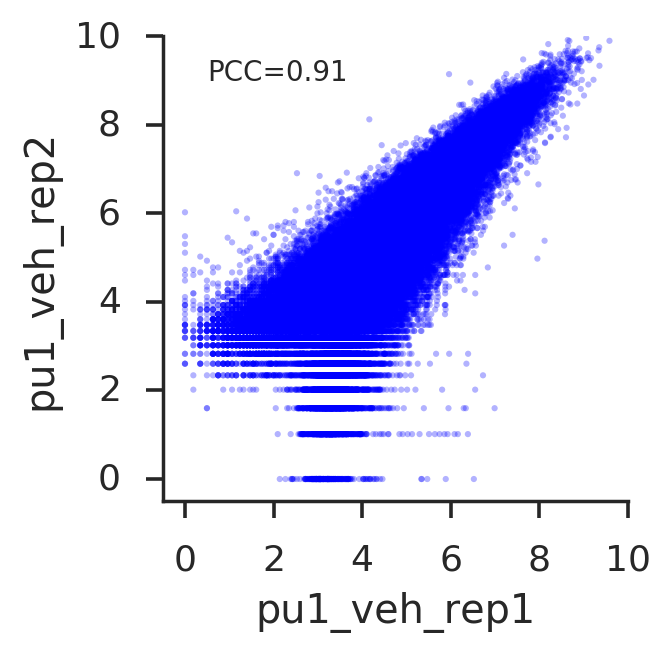

In [163]:
for treatment in ['veh']:
    for factor in ['atf3', 'cjun', 'jund', 'pu1']:
        rep1_label = '_'.join([factor, treatment, 'rep1'])
        rep2_label = '_'.join([factor, treatment, 'rep2'])
        rep1_indices = set(summary_frame[summary_frame[rep1_label] > 0].index.values)
        rep2_indices = set(summary_frame[summary_frame[rep2_label] > 0].index.values)
        idr_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'idr'])] > 0].index.values)
        indices = sorted(rep1_indices.union(rep2_indices).union(idr_indices))
        
        rep1_tags = annotated_frame.ix[indices, rep1_label].values
        rep2_tags = annotated_frame.ix[indices, rep2_label].values
        corr, pval = scipy.stats.pearsonr(rep1_tags, rep2_tags)
        with sns.axes_style('ticks'):
            plt.figure(figsize=(3,3))
            plt.scatter(np.log2(rep1_tags+1),
                        np.log2(rep2_tags+1),
                        edgecolor='None', 
                        s=5,
                        alpha=0.3)
            plt.annotate(xy=(0.5,9), s='PCC='+str(corr)[:4], size=10)
            plt.xlim(-0.5, 10)
            plt.ylim(-0.5, 10)
            ax = plt.gca()
            ax.set_aspect(1.0)
            plt.xlabel(rep1_label)
            plt.ylabel(rep2_label)
            sns.despine()
        plt.show()                                      

## Visualize Difference Between Monomers

In [194]:
def quantile_normalize(vals1, vals2):
    '''
    input: two scalar arrays
    output: two quantile normalized scalar arrays
    '''
    vals1 = np.array(vals1)
    vals2 = np.array(vals2)
    
    ranks_1 = scipy.stats.rankdata(vals1, method = 'ordinal')
    ranks_2 = scipy.stats.rankdata(vals2, method = 'ordinal')
    
    sorted_vals_1 = sorted(vals1)
    sorted_vals_2 = sorted(vals2)
    means = np.mean([sorted_vals_1,sorted_vals_2], axis=0)
    
    rank_mean_dict = dict(zip(sorted(ranks_1), sorted(means)))
    normalized_vals_1 = np.array([rank_mean_dict[x] for x in ranks_1])
    normalized_vals_2 = np.array([rank_mean_dict[x] for x in ranks_2])
    return normalized_vals_1, normalized_vals_2

In [169]:
conditions = set()
for col in annotated_frame.columns[6:]:
    condition = '_'.join(col.split('_')[:2])
    conditions.add(condition)
annotated_mean_frame = annotated_frame[[]]
for condition in sorted(conditions):
    mean_tags = annotated_frame[[x for x in annotated_frame.columns if condition in x]].mean(axis=1)
    annotated_mean_frame[condition] = mean_tags.values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [267]:
indices = set()
factors=['atf3', 'cjun', 'jund']
for treatment in ['veh']:
    for factor in factors:
        idr_indices = set(summary_frame[summary_frame['_'.join([factor, treatment, 'idr'])] > 0].index.values)
        indices = indices.union(idr_indices)
indices = sorted(indices)
data = annotated_mean_frame[annotated_mean_frame.index.isin(indices)][['atf3_veh', 'cjun_veh', 'jund_veh']]
data = data[data.min(axis=1)>0]
normed_data = data[[]]
for col in data:
    normalized_vals_1, normalized_vals_2 = quantile_normalize(data['atf3_veh'].values, data[col].values)
    normed_data[col] = normalized_vals_2


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [268]:
medians = normed_data.median(axis=1)
mins = normed_data.min(axis=1)
maxes = normed_data.max(axis=1)
ranges = maxes - mins
normed_distances = normed_data[[]]
for col in data:
    normed_distances[col] = (data[col].values- medians)/ranges

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


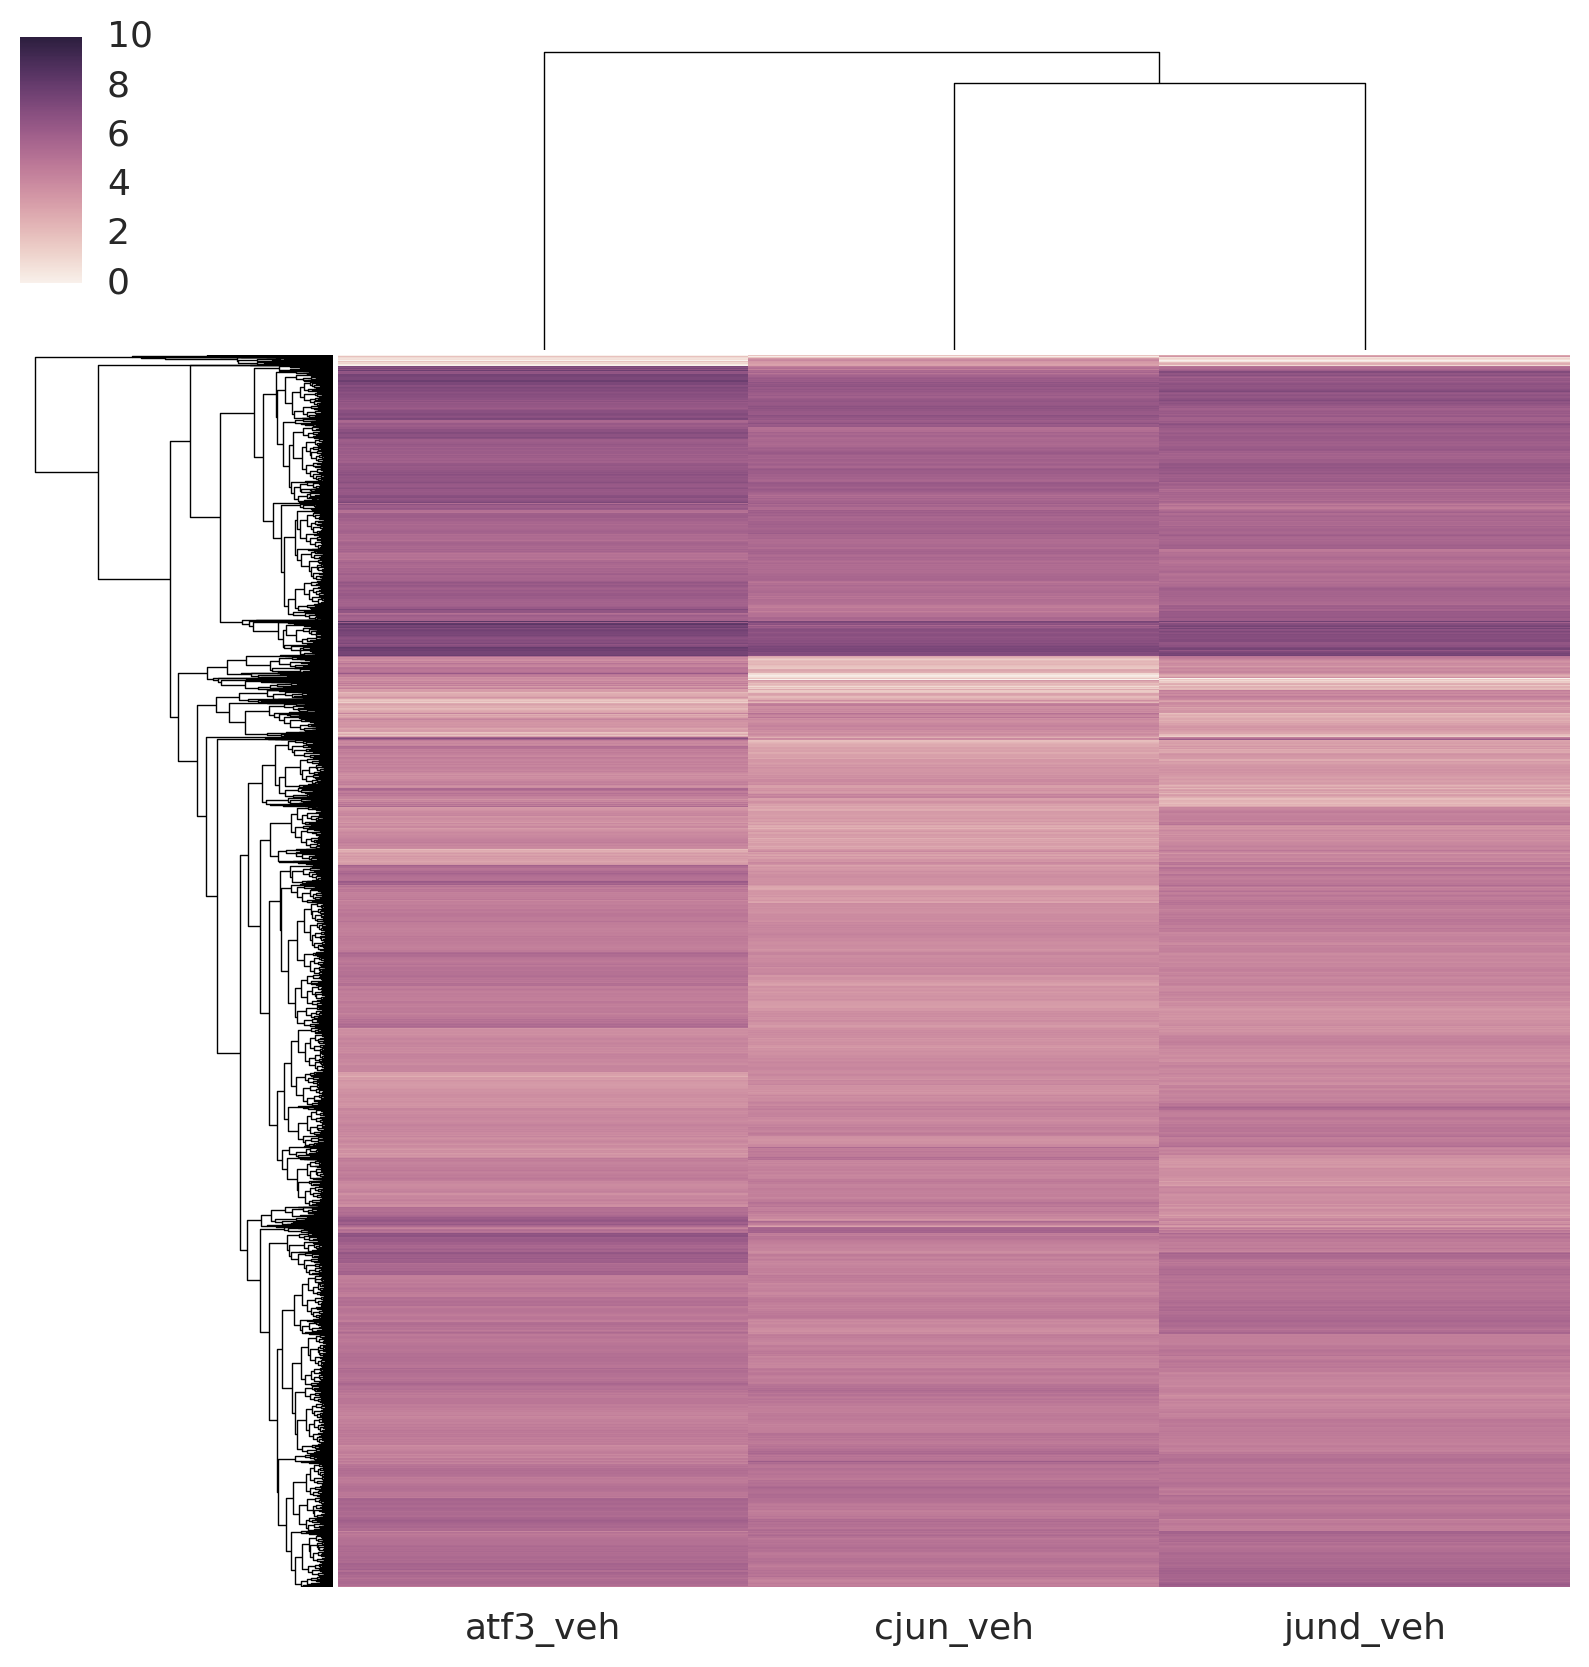

In [235]:
sns.clustermap(np.log2(data+1), 
               yticklabels=False,
               vmax=10,
#                metric = 'correlation',
#                method = 'centroid'
              )

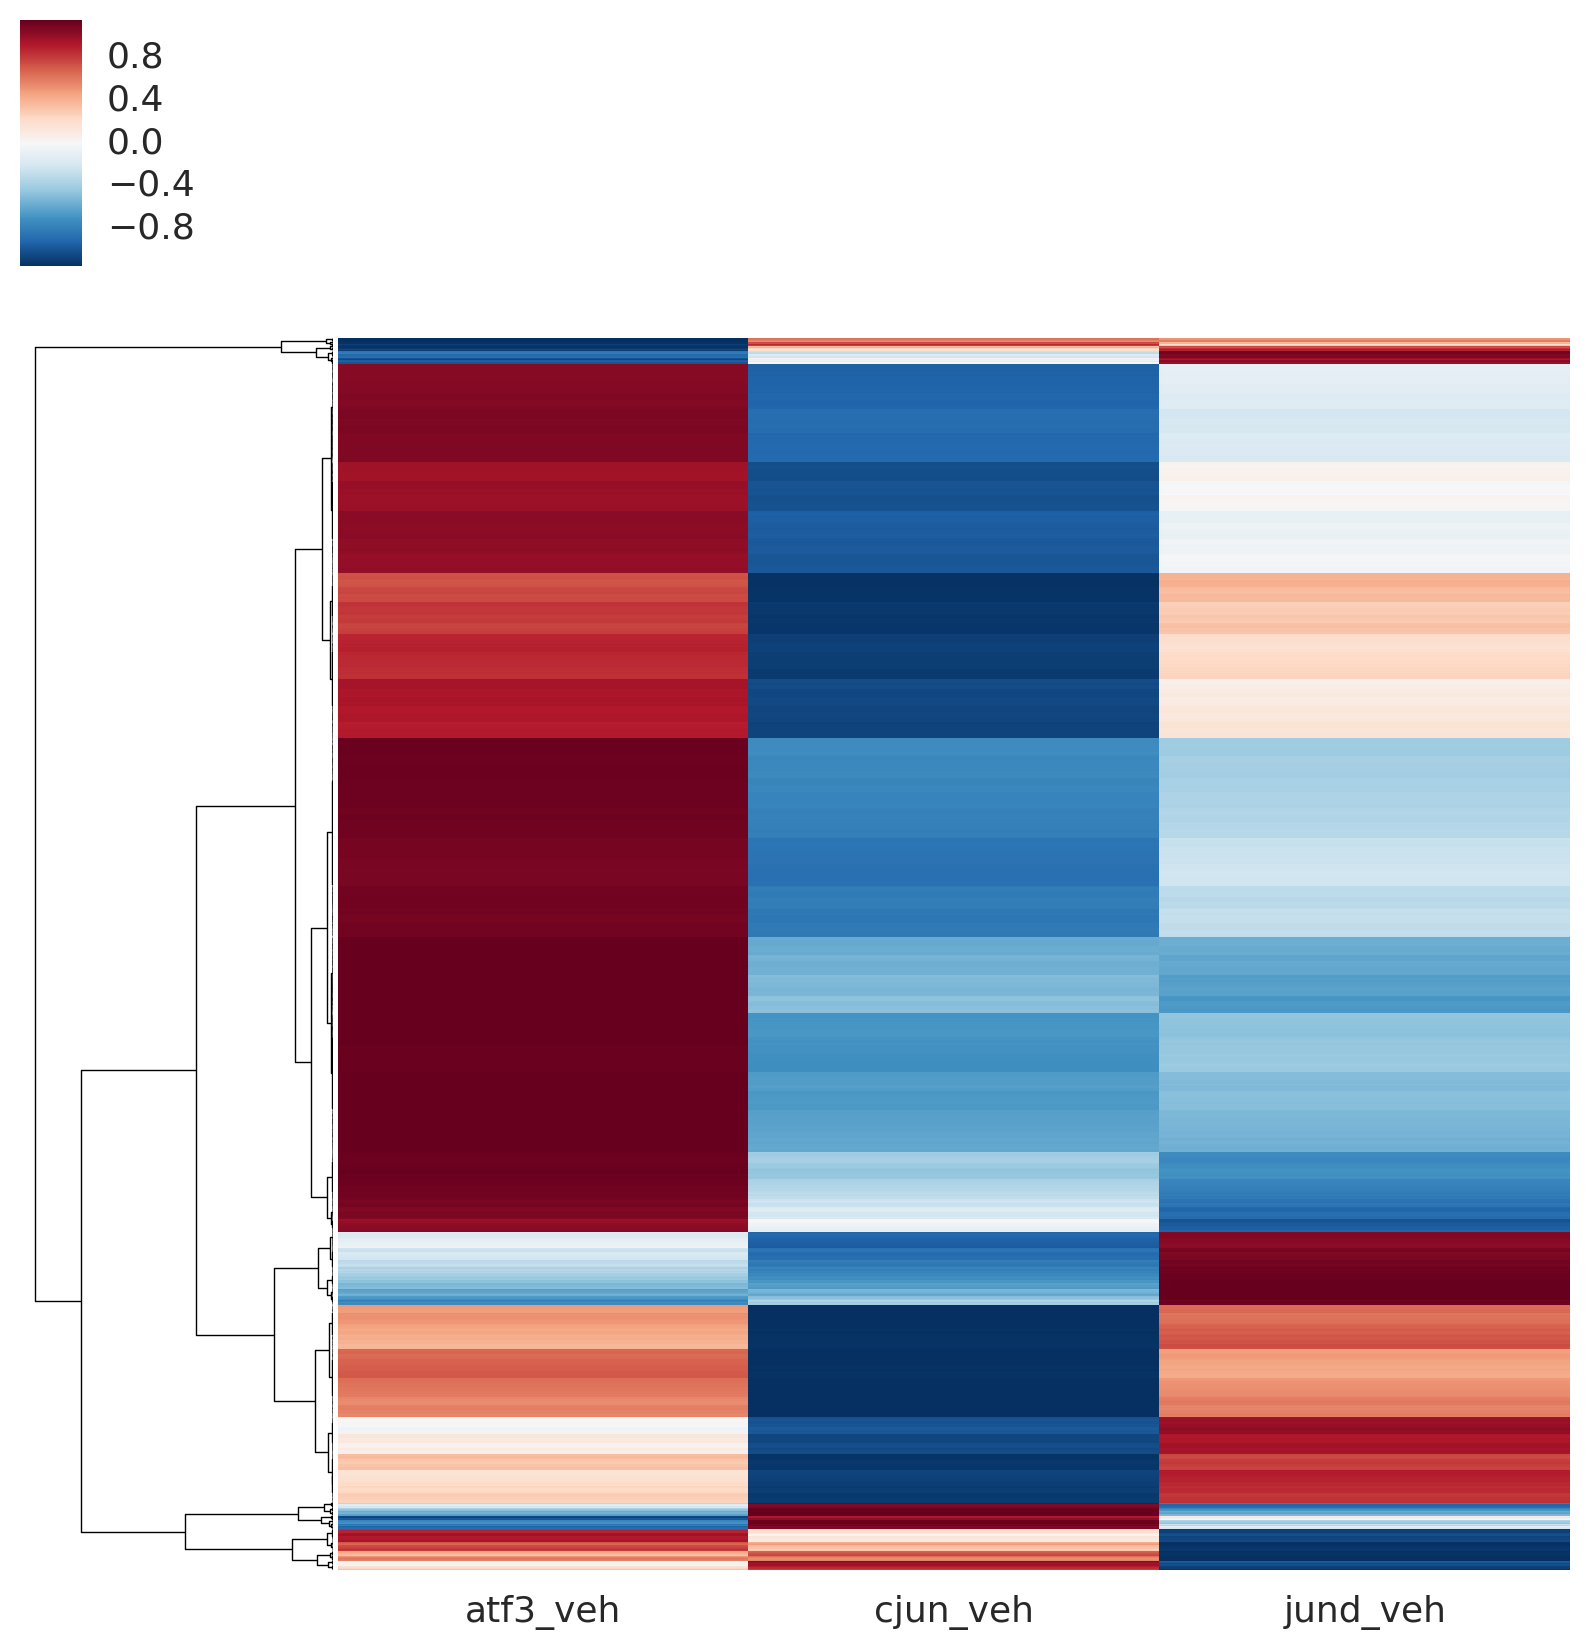

In [285]:
cg = sns.clustermap(data,
                    yticklabels=False,
                    col_cluster=False,
                    z_score=0,
                    metric = 'correlation',
                    method = 'centroid')

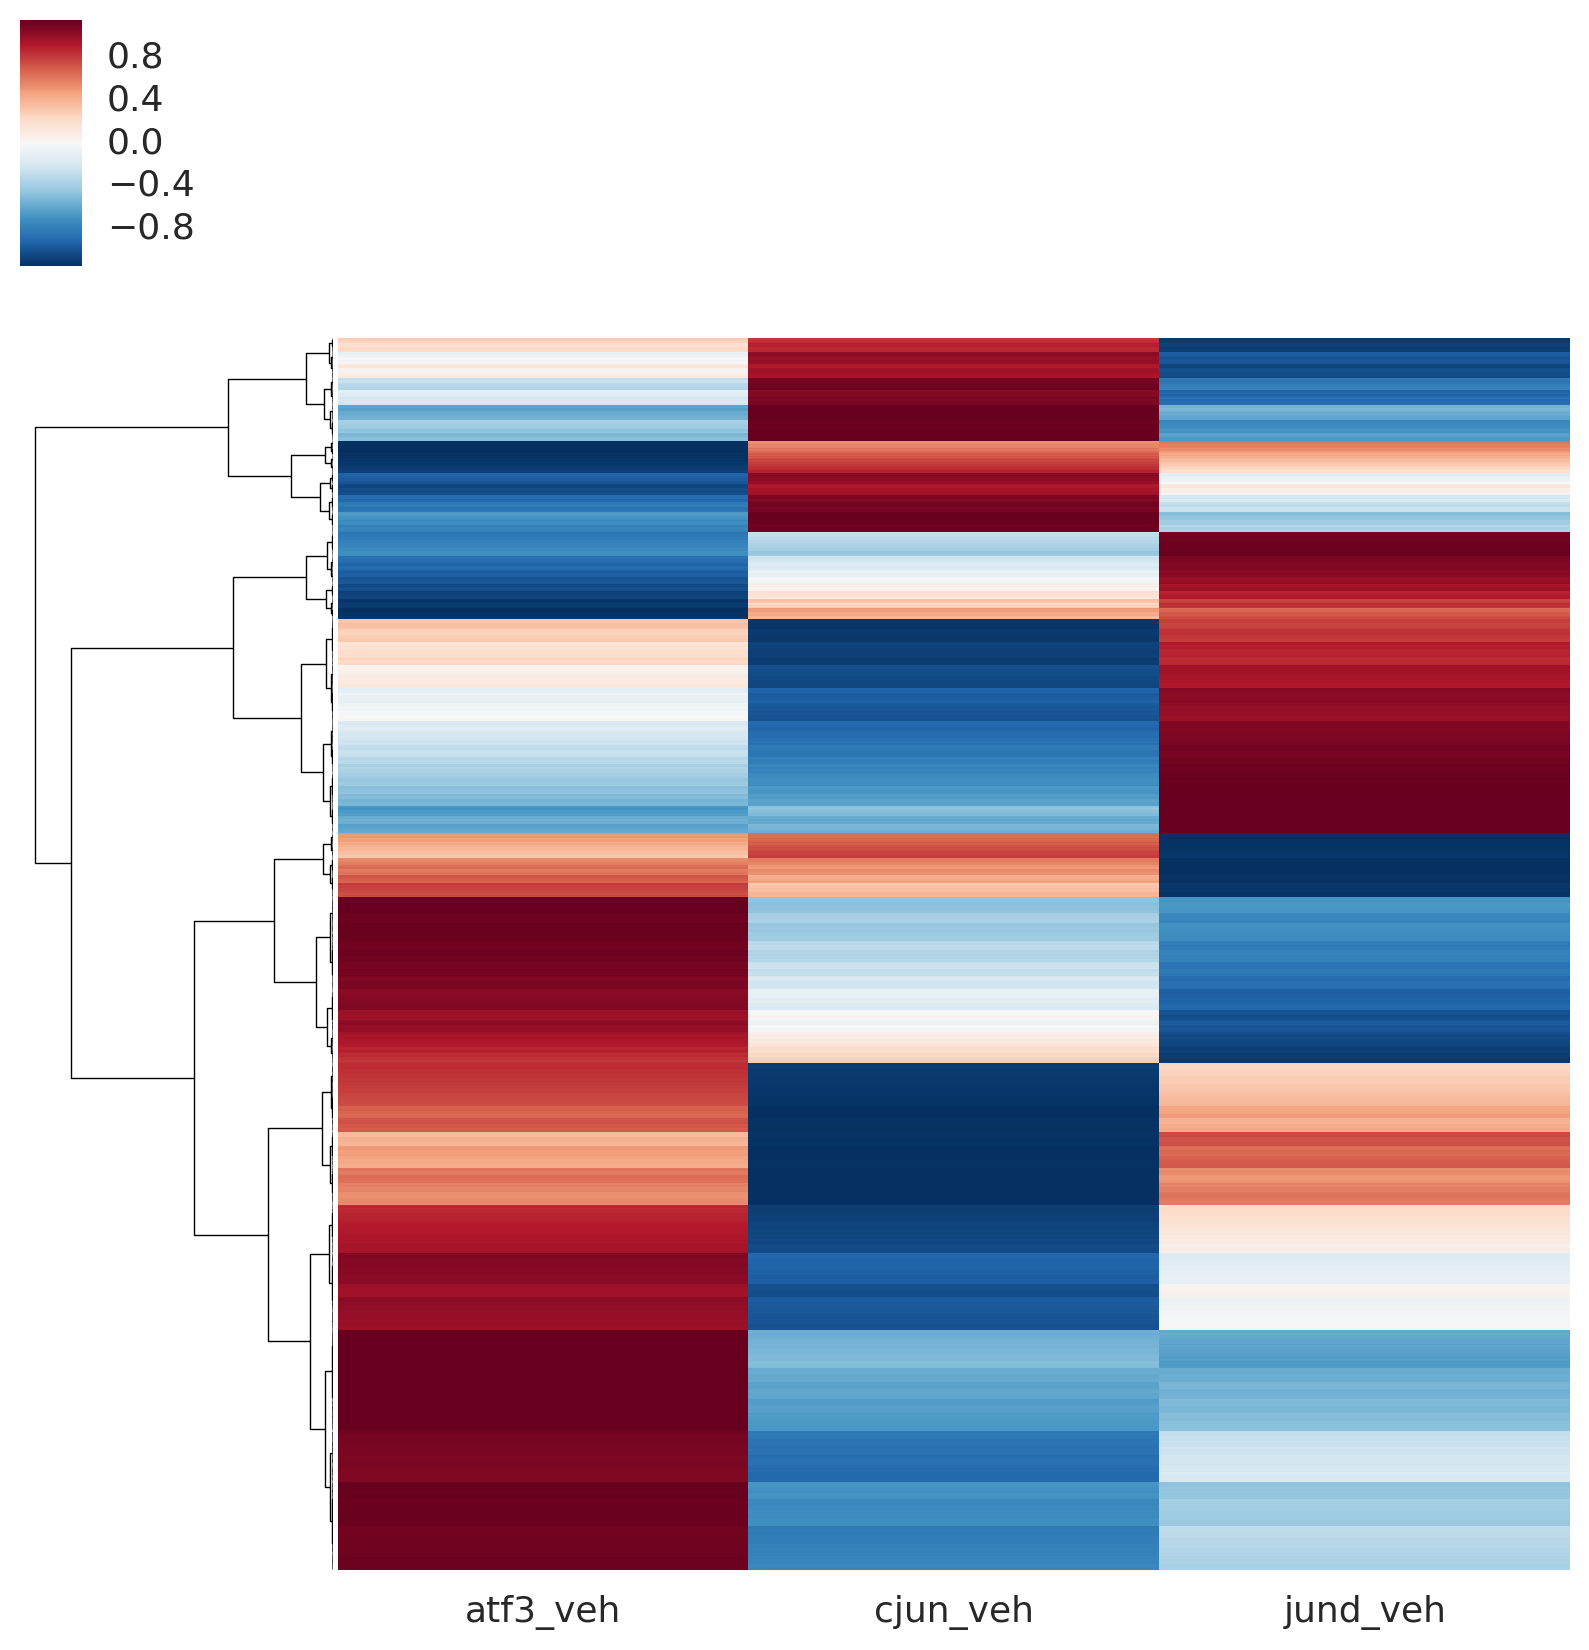

In [283]:
cg = sns.clustermap(normed_data,
                    yticklabels=False,
                    z_score=0,
                    col_cluster=False,
                    metric = 'correlation',
                    method = 'centroid')